# **Facial Expression Recognition Competition (30%)**
For this competition, we will use the a facial classification dataset. The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0: Angry, 1: Disgust, 2: Fear, 3: Happy, 4: Sad, 5: Surprise, 6: Neutral). The training set consists of 28,709 examples and the public test set consists of 3,589 examples.

We provide baseline code that includes the following features:

*   Loding and Analysing the FER-2013 dataset using torchvision.
*   Defining a simple convolutional neural network.
*   How to use existing loss function for the model learning.
*   Train the network on the training data.
*   Test the trained network on the testing data.
*   Generate prediction for the random test image(s).

The following changes could be considered:
-------
1. Change of advanced training parameters: Learning Rate, Optimizer, Batch-size, Number of Max Epochs, and Drop-out.
2. Use of a new loss function.
3. Data augmentation
4. Architectural Changes: Batch Normalization, Residual layers, Attention Block, and other varients.

Marking Rules:
-------
We will mark the competition based on the final test accuracy on testing images and your report.

Final mark (out of 100) = acc_mark + efficiency mark + report mark  
###Acc_mark 20:

We will rank all the submission results based on their test accuracy. Zero improvement over the baseline yields 0 marks. Maximum improvement over the baseline will yield 20 marks. There will be a sliding scale applied in between.

###Efficiency mark 20:

Efficiency considers not only the accuracy, but the computational cost of running the model (flops: https://en.wikipedia.org/wiki/FLOPS). Efficiency for our purposes is defined to be the ratio of accuracy (in %) to Gflops. Please report the computational cost for your final model and include the efficiency calculation in your report. Maximum improvement over the baseline will yield 20 marks. Zero improvement over the baseline yields zero marks, with a sliding scale in between.

###Report mark 60:  
Your report should comprise:
1. An introduction showing your understanding of the task and of the baseline model: [20 marks]

2. A description of how you have modified aspects of the system to improve performance. [20 marks]

A recommended way to present a summary of this is via an "ablation study" table, eg:

|Method1|Method2|Method3|Accuracy|
|---|---|---|---|
|N|N|N|60%|
|Y|N|N|65%|
|Y|Y|N|77%|
|Y|Y|Y|82%|

3. Explanation of the methods for reducing the computational cost and/or improve the trade-off between accuracy and cost: [10 marks]

4. Limitations/Conclusions: [10 marks]


In [5]:
##################################################################################################################################
### Subject: Computer Vision
### Year: 2025
### Student Name: ABC, XYZ
### Student ID: a123456, a654321
### Comptetion Name: Facial Expression Recognition/Classification
### Final Results:
### ACC:         GFLOPs:
##################################################################################################################################

In [6]:
# we use fvcore to calculate the FLOPs
!pip install fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=357dd849cf2ec27b051ac975da49e1ba12f4a2c902f1dec2b3076a401d872770
  Stored in directory: /root/.cache/pip/wheels/ed/9f/a5/e4f5b27454ccd4596bd8b62432c7d6b1ca9fa22aef9d70a16a
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=bf5ca4df2cd2863c969ddf77babba1dabfb009b58959cd773a11141e7cb22045
  Stored in directory: /root/.cache/pip/wheels/7c/96/04/4f5f31ff812f684f69f40cb1634357812220aac58d4698048c
Successfully built fvcore iopath


In [7]:
# Importing libraries.

from pathlib import Path
from copy import deepcopy
from datetime import datetime

import csv
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as T

# To avoid non-essential warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from tqdm import tqdm
import torch.nn.functional as F
from torch.optim import AdamW, SGD
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import WeightedRandomSampler
from torch.utils.data.dataloader import default_collate
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR

from fvcore.nn import FlopCountAnalysis

from torchvision.utils import make_grid
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder

In [8]:
# Mounting G-Drive to get your dataset.
# To access Google Colab GPU; Go To: Edit >>> Network Settings >>> Hardware Accelarator: Select GPU.
# Reference: https://towardsdatascience.com/google-colab-import-and-export-datasets-eccf801e2971
from google.colab import drive
drive.mount('/content/drive')

# Dataset path. Ensure that the file path correspond to the path you have here. It is expected that you unzip the data folders before running the notebook.
data_directory ='/content/drive/MyDrive/Colab Notebooks/deep_learning_challenge/fer2013.csv'

Mounted at /content/drive


In [9]:
# Reading the dataset file using Pandas read_csv function and print the first
# 5 samples.
#
# Reference: https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
data_df = pd.read_csv(data_directory)
data_df.head(4)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training


In [10]:
# Mapping of the Facial Expression Labels.
Labels = {
    0:'Angry',
    1:'Disgust',
    2:'Fear',
    3:'Happy',
    4:'Sad',
    5:'Surprise',
    6:'Neutral'
}
Labels

{0: 'Angry',
 1: 'Disgust',
 2: 'Fear',
 3: 'Happy',
 4: 'Sad',
 5: 'Surprise',
 6: 'Neutral'}

In [11]:
# E1: For reproducibility
def seed_everything(seed: int=42):
    import os, random
    import numpy as np
    import torch
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True  # exact reproducibility
    torch.backends.cudnn.benchmark = False     # disable heuristics that add nondeterminism

SEED = 42
seed_everything(SEED)


In [12]:
LOG_FILE = Path("results_log.csv")

def log_experiment_result(exp_label, val_loss, val_acc, test_loss, test_acc, gflops, efficiency, notes=""):
    """
    Append a single experiment's results to results_log.csv.
    Creates the CSV with a header if it doesn't exist yet.
    """
    file_exists = LOG_FILE.exists()
    with open(LOG_FILE, mode="a", newline="") as f:
        writer = csv.writer(f)
        if not file_exists:
            writer.writerow([
                "timestamp", "experiment", "val_loss", "val_acc",
                "test_loss", "test_acc", "GFLOPs", "Efficiency", "notes"
            ])
        writer.writerow([
            datetime.now().isoformat(timespec="seconds"),
            exp_label,
            f"{val_loss:.4f}", f"{val_acc:.4f}",
            f"{test_loss:.4f}", f"{test_acc:.4f}",
            f"{gflops:.5f}", f"{efficiency:.2f}",
            notes
        ])
    print(f"[LOGGED] {exp_label} → results_log.csv")


In [13]:
def compute_gflops_nonmutating(model, input_shape=(1, 1, 48, 48)):
    """
    Clone the model, move the clone to CPU, and compute GFLOPs without touching the real model.
    """
    m_cpu = deepcopy(model).to("cpu").eval()
    dummy = torch.randn(*input_shape, device="cpu")
    with torch.no_grad():
        flops = FlopCountAnalysis(m_cpu, dummy).total()  # fvcore returns FLOPs
    del m_cpu
    return flops / 1e9

def calc_and_log(exp_label, model, val_loader, test_loader, notes="", input_shape=(1, 1, 48, 48)):
    """
    Evaluate on val/test, compute GFLOPs & Efficiency, log, and print.
    Never mutates the model's device.
    """
    # Remember where the real model lives
    orig_dev = next(model.parameters()).device
    model.eval()

    # Evaluate (your DeviceDataLoader already moves batches to the right device)
    val_res  = evaluate(model, val_loader)   # {'val_loss': ..., 'val_acc': ...}
    test_res = evaluate(model, test_loader)  # same keys

    # FLOPs on a CPU clone; failures won't poison state
    try:
        gflops = compute_gflops_nonmutating(model, input_shape=input_shape)
    except Exception as e:
        print(f"[WARN] GFLOPs computation failed: {e}")
        gflops = float('nan')

    acc_percent = float(test_res["val_acc"]) * 100.0
    efficiency = (acc_percent / gflops) if (gflops and gflops > 0) else float('nan')

    print(f"\n=== {exp_label} RESULTS ===")
    print(f"Validation -> loss: {val_res['val_loss']:.4f}, acc: {val_res['val_acc']:.4f}")
    print(f"Test       -> loss: {test_res['val_loss']:.4f}, acc: {test_res['val_acc']:.4f}")
    if gflops == gflops:  # not NaN
        print(f"GFLOPs     -> {gflops:.5f}")
        print(f"Efficiency -> {efficiency:.2f}")

    # Log to CSV (your existing helper)
    log_experiment_result(
        exp_label=exp_label,
        val_loss=val_res["val_loss"],
        val_acc=val_res["val_acc"],
        test_loss=test_res["val_loss"],
        test_acc=test_res["val_acc"],
        gflops=gflops,
        efficiency=efficiency,
        notes=notes
    )

    # Sanity check: we never moved the real model
    assert next(model.parameters()).device == orig_dev, "calc_and_log must not move the model"

    return {
        "val_loss": val_res["val_loss"],
        "val_acc":  val_res["val_acc"],
        "test_loss": test_res["val_loss"],
        "test_acc":  test_res["val_acc"],
        "gflops":    gflops,
        "efficiency": efficiency,
    }


In [14]:
# Categorizing the dataset to three categories.
# Training: To train the model.
# PrivateTest: To test the train model; commonly known as Validation.
# PublicTest: To test the final model on Test set to check how your model perfomed. Do not use this data as your validation data.
train_df = data_df[data_df['Usage']=='Training']
valid_df = data_df[data_df['Usage']=='PublicTest']
test_df = data_df[data_df['Usage']=='PrivateTest']
print(train_df.head())
print(valid_df.head(-1))

   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training
       emotion                                             pixels       Usage
28709        0  254 254 254 254 254 249 255 160 2 58 53 70 77 ...  PublicTest
28710        1  156 184 198 202 204 207 210 212 213 214 215 21...  PublicTest
28711        4  69 118 61 60 96 121 103 87 103 88 70 90 115 12...  PublicTest
28712        6  205 203 236 157 83 158 120 116 94 86 155 180 2...  PublicTest
28713        3  87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...  PublicTest
...        ...                                                ...         ...
32292        3  0 0 0 

In [15]:
# Test-check to see wether usage labels have been allocated to the dataset/not.
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
print(test_df.head())
print('   -----   -------    -------    --------     -----    -------')
print(valid_df.head())

   emotion                                             pixels        Usage
0        0  170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...  PrivateTest
1        5  7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...  PrivateTest
2        6  232 240 241 239 237 235 246 117 24 24 22 13 12...  PrivateTest
3        4  200 197 149 139 156 89 111 58 62 95 113 117 11...  PrivateTest
4        2  40 28 33 56 45 33 31 78 152 194 200 186 196 20...  PrivateTest
   -----   -------    -------    --------     -----    -------
   emotion                                             pixels       Usage
0        0  254 254 254 254 254 249 255 160 2 58 53 70 77 ...  PublicTest
1        1  156 184 198 202 204 207 210 212 213 214 215 21...  PublicTest
2        4  69 118 61 60 96 121 103 87 103 88 70 90 115 12...  PublicTest
3        6  205 203 236 157 83 158 120 116 94 86 155 180 2...  PublicTest
4        3  87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...  PublicTest


In [16]:
# Preview of the training sample and associated labels.
def show_example(df, num):
    print('expression: ' ,df.iloc[num] )
    image = np.array([[int(i) for i in x.split()] for x in df.loc[num, ['pixels']]])
    print(image.shape)
    image = image.reshape(48,48)
    plt.imshow(image, interpolation='nearest', cmap='gray')
    plt.show()

expression:  emotion                                                    0
pixels     179 175 176 170 149 136 129 118 105 91 87 81 7...
Usage                                               Training
Name: 107, dtype: object
(1, 2304)


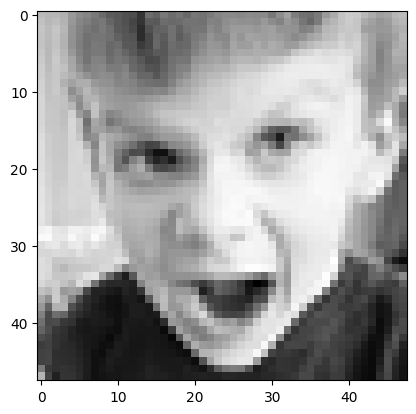

In [17]:
show_example(train_df, 107)

In [18]:
# Normalization of the train and validation data.
class expressions(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.loc[index]
        image, label = np.array([x.split() for x in self.df.loc[index, ['pixels']]]), row['emotion']
        #image = image.reshape(1,48,48)
        image = np.asarray(image).astype(np.uint8).reshape(48,48,1)
        #image = np.reshape(image,(1,48,48))


        if self.transforms:
            image = self.transforms(image)

        return image.clone().detach(), label

In [19]:
#import albumentations as A
stats = ([0.5],[0.5])

In [20]:
train_tsfm = T.Compose([
    T.ToPILImage(),
    T.Grayscale(num_output_channels=1),
    T.ToTensor(),
    T.Normalize(*stats,inplace=True),
])
valid_tsfm = T.Compose([
    T.ToPILImage(),
    T.Grayscale(num_output_channels=1),
    T.ToTensor(),
    T.Normalize(*stats,inplace=True)
])

In [21]:
train_ds = expressions(train_df, train_tsfm)
valid_ds = expressions(valid_df, valid_tsfm)
test_ds = expressions(test_df, valid_tsfm)

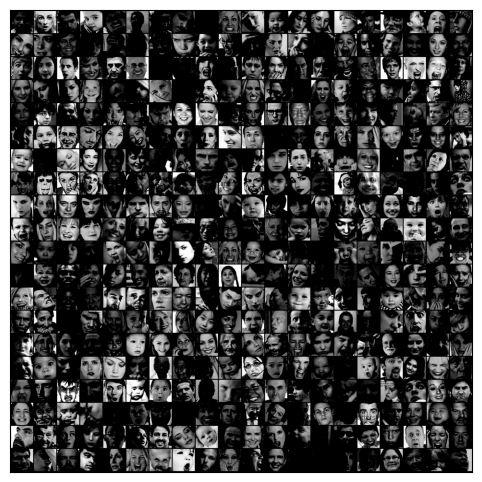

In [22]:
batch_size = 400
train_dl = DataLoader(train_ds, batch_size, shuffle=True,
                      num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2,
                    num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2,
                    num_workers=2, pin_memory=True)
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=20).permute(1, 2, 0))
        break

show_batch(train_dl)

In [23]:
# Evaluation metric - Accuracy in this case.
input_size = 48*48
output_size = len(Labels)

def accuracy(output, labels):
    predictions, preds = torch.max(output, dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [24]:
# Expression model class for training and validation purpose.

class expression_model(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch[{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [25]:
# To check wether Google Colab GPU has been assigned/not.
torch.cuda.is_available()
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()
print(f'You are training on: {device}.')

You are training on: cuda.


In [26]:
def to_device(data, device):
    # Sequences
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]

    # Dicts
    if isinstance(data, dict):
        return {k: to_device(v, device) for k, v in data.items()}

    # Plain scalars (lam from mixup/cutmix, etc.)
    if isinstance(data, (float, int)):
        import torch
        return torch.tensor(data, device=device)

    # Strings / None / bool → leave as-is (but your collate no longer returns strings)
    if isinstance(data, (str, type(None), bool)):
        return data

    # Tensors / objects with .to()
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [27]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [28]:
TRAIN_LOADER = train_dl     # Training
VAL_LOADER   = test_dl      # PrivateTest (validation)
TEST_LOADER  = valid_dl     # PublicTest (final test)

In [29]:
for _name in ["compute_class_weights_from_df", "make_balanced_sampler_from_df", "criterion_builder"]:
    if _name in globals():
        del globals()[_name]

def compute_class_weights_from_df(df, num_classes=7):
    """
    Returns 1D tensor of per-class weights (inverse frequency, normalized).
    CPU tensor on purpose; we move it to the right device when we build the loss.
    """
    counts = np.bincount(df["emotion"].values, minlength=num_classes).astype(np.float32)
    weights = counts.sum() / (counts + 1e-6)   # inverse frequency
    weights = weights / weights.mean()         # normalize
    return torch.tensor(weights, dtype=torch.float32)  # keep on CPU

CLASS_WEIGHTS_CPU = compute_class_weights_from_df(train_df, num_classes=7)

def make_balanced_sampler_from_df(df, num_classes=7):
    """
    WeightedRandomSampler over examples (NOT classes). Useful if you want balanced sampling.
    You do NOT need this for every run; it’s optional.
    """
    counts = np.bincount(df["emotion"].values, minlength=num_classes).astype(np.float32)
    inv = 1.0 / (counts + 1e-6)
    sample_w = inv[df["emotion"].values]
    return WeightedRandomSampler(sample_w, num_samples=len(sample_w), replacement=True)

In [30]:
# Basic model - 1 layer
simple_model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)
simple_model.to(device)

Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [31]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([400, 1, 48, 48])
out.shape: torch.Size([400, 8, 24, 24])


In [32]:
# E1: Add dropout AFTER each ReLU in the FC head, leaving the conv body untouched.
# This keeps the architecture logically identical for FLOPs (dropout is a no-op in eval).
def add_dropout_to_head(model: nn.Module, p: float = 0.30):
    """
    Assumes your model has model.network = nn.Sequential([... convs ..., nn.Flatten(), FC..., ReLU..., ..., classifier]).
    We set a flag after Flatten() and insert nn.Dropout(p) after every ReLU that occurs in the head.
    """
    assert isinstance(model.network, nn.Sequential), "Expected model.network to be nn.Sequential"
    new_layers = []
    in_head = False
    for m in model.network:
        new_layers.append(m)
        if isinstance(m, nn.Flatten):
            in_head = True
        # Only add dropout in head, right after FC ReLUs
        if in_head and isinstance(m, nn.ReLU):
            new_layers.append(nn.Dropout(p))
    model.network = nn.Sequential(*new_layers)
    return model


In [33]:
# Model - 7 layer
class expression(expression_model):
    def __init__(self,classes):
        super().__init__()
        self.num_classes = classes
        self.network = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),  #(input channels, output channels)
            nn.ReLU(),
            nn.Conv2d(8, 32, kernel_size=3, padding=1),  #(input channels, output channels)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 24 x 24

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 12 x 12

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 6 x 6

            nn.Flatten(),
            nn.Linear(256*6*6, 2304),
            nn.ReLU(),
            nn.Linear(2304, 1152),
            nn.ReLU(),
            nn.Linear(1152, 576),
            nn.ReLU(),
            nn.Linear(576,288),
            nn.ReLU(),
            nn.Linear(288,144),
            nn.ReLU(),
            nn.Linear(144,self.num_classes))

    def forward(self, xb):
        return self.network(xb)

In [34]:
# Model print
model = to_device(expression(classes = 7), device)
model

expression(
  (network): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Flatten(start_dim=1, end_dim=-1)
    (18): Linear(in_

In [35]:
# Functions for evaluation and training.
@torch.no_grad()
def evaluate(model, valid_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in valid_dl]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_dl, valid_dl, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_dl:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, valid_dl)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [31]:
evaluate(model, valid_dl)

{'val_loss': 1.9515440464019775, 'val_acc': 0.16891901195049286}

In [36]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [33]:
history = fit(num_epochs, lr, model, train_dl, valid_dl, opt_func)

Epoch[0], val_loss: 1.8097, val_acc: 0.2486
Epoch[1], val_loss: 1.7924, val_acc: 0.2656
Epoch[2], val_loss: 1.6792, val_acc: 0.3388
Epoch[3], val_loss: 1.5406, val_acc: 0.3881
Epoch[4], val_loss: 1.4379, val_acc: 0.4315
Epoch[5], val_loss: 1.3553, val_acc: 0.4543
Epoch[6], val_loss: 1.3130, val_acc: 0.4837
Epoch[7], val_loss: 1.2890, val_acc: 0.4913
Epoch[8], val_loss: 1.2475, val_acc: 0.5124
Epoch[9], val_loss: 1.2488, val_acc: 0.5161


In [37]:
# Plots for accuracy and loss during training period.
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

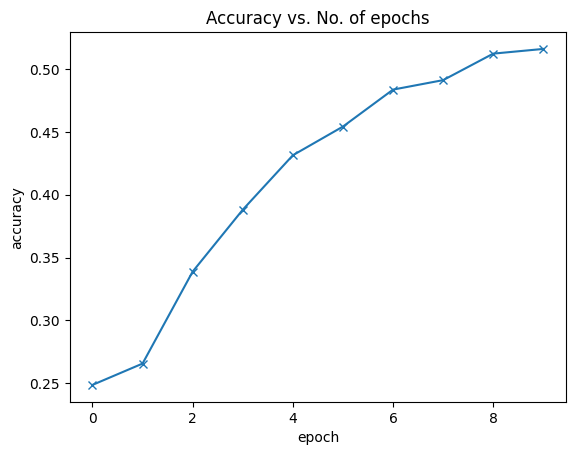

In [35]:
plot_accuracies(history)

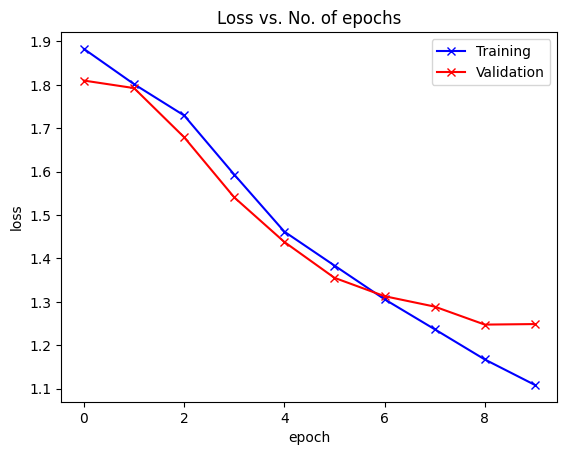

In [36]:
plot_losses(history)

In [39]:
# Model evaluation on test data.
result = evaluate(model, TEST_LOADER)
result

# Prediction function to evaluate the model.
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return Labels[preds[0].item()]

Label: Angry , Predicted: Neutral


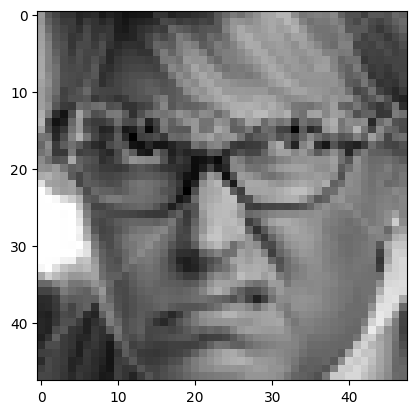

In [40]:
img, label = test_ds[0]
plt.imshow(img[0], interpolation='nearest', cmap='gray')
img = img.to(device)
print('Label:', Labels[label], ', Predicted:', predict_image(img, model))

Label: Angry , Predicted: Neutral


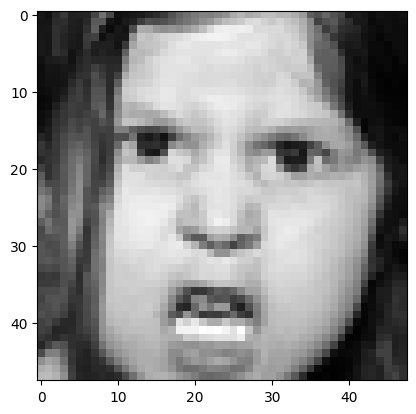

In [41]:
img, label = test_ds[110]
plt.imshow(img[0], interpolation='nearest', cmap='gray')
img = img.to(device)
print('Label:', Labels[label], ', Predicted:', predict_image(img, model))

##FLOPs
In deep learning, FLOPs (Floating Point Operations) quantify the total number of arithmetic operations—such as additions, multiplications, and divisions—that a model performs during a single forward pass (i.e., when making a prediction). This metric serves as an indicator of a model’s computational complexity. When discussing large-scale models, FLOPs are often expressed in GFLOPs (Giga Floating Point Operations), where 1 GFLOP equals one billion operations. This unit helps in comparing the computational demands of different models.

In [ ]:
# from fvcore.nn import FlopCountAnalysis
# input = torch.randn(1, 1, 48, 48) # The input size should be the same as the size that you put into your model
# #Get the network and its FLOPs
# num_classes = 7
# model = expression(num_classes)
# flops = FlopCountAnalysis(model, input)
# print(f"FLOPs: {flops.total()/1e9:.5f} GFLOPs")

FLOPs: 0.32751 GFLOPs


### Logging

In [40]:
calc_and_log(
    exp_label="E0_baseline",
    model=model,
    val_loader=VAL_LOADER,
    test_loader=TEST_LOADER,
    notes="Baseline model, Adam lr=0.001, no dropout, no aug"
)


=== E0_baseline RESULTS ===
Validation -> loss: 1.2146, acc: 0.5315
Test       -> loss: 1.2488, acc: 0.5161
GFLOPs     -> 0.32751
Efficiency -> 157.59
[LOGGED] E0_baseline → results_log.csv


{'val_loss': 1.214639663696289,
 'val_acc': 0.5315494537353516,
 'test_loss': 1.2487682104110718,
 'test_acc': 0.5161297917366028,
 'gflops': 0.327505392,
 'efficiency': 157.59428832139739}

### Experiment 1:

In [42]:
# E1: Optimizer / Scheduler factory
def make_optimizer_scheduler(model, *, epochs, steps_per_epoch, opt_name="adamw",
                             lr=3e-3, weight_decay=1e-4, schedule="cosine"):
    if opt_name.lower() == "sgd":
        optimizer = SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=weight_decay)
    else:
        optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    if schedule.lower() == "onecycle":
        scheduler = OneCycleLR(optimizer, max_lr=lr, epochs=epochs, steps_per_epoch=steps_per_epoch)
        step_per_batch = True
    elif schedule.lower() == "cosine":
        scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=lr * 0.01)
        step_per_batch = False
    else:
        scheduler, step_per_batch = None, False

    return optimizer, scheduler, step_per_batch

def make_criterion(num_classes, label_smoothing=0.05, weight=None):
    try:
        return nn.CrossEntropyLoss(label_smoothing=label_smoothing, weight=weight)
    except TypeError:
        class LabelSmoothingCE(nn.Module):
            def __init__(self, n_classes, eps=0.05, weight=None):
                super().__init__()
                self.n_classes = n_classes
                self.eps = eps
                self.weight = weight
            def forward(self, logits, target):
                import torch
                log_prob = torch.log_softmax(logits, dim=1)
                with torch.no_grad():
                    true_dist = torch.zeros_like(logits)
                    true_dist.fill_(self.eps / (self.n_classes - 1))
                    true_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.eps)
                loss = torch.sum(-true_dist * log_prob, dim=1)
                if self.weight is not None:
                    w = self.weight.to(logits.device)[target]
                    loss = loss * w
                return loss.mean()
        return LabelSmoothingCE(num_classes, label_smoothing, weight)

In [43]:
# E1: Fit loop with optional scheduler and AMP. Reuses your evaluate() and model.epoch_end().
def fit_e1(epochs, model, train_loader, val_loader, optimizer, criterion,
           scheduler=None, step_sched_per_batch: bool = False,
           grad_clip: float | None = None, use_amp: bool = True, device: str | torch.device = "cuda"):
    history = []
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    model.to(device)
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=use_amp):
                out = model(xb)
                loss = criterion(out, yb)

            scaler.scale(loss).backward()
            if grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            scaler.step(optimizer)
            scaler.update()

            if scheduler is not None and step_sched_per_batch:
                scheduler.step()

        # end-of-epoch scheduler step (for cosine etc.)
        if scheduler is not None and not step_sched_per_batch:
            scheduler.step()

        # reuse your notebook's evaluation logic
        result = evaluate(model, val_loader)  # must exist in your notebook already
        # If your base class has epoch_end, keep the same printout style:
        try:
            model.epoch_end(epoch, result)
        except Exception:
            print(f"Epoch[{epoch}], val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")
        history.append(result)

    return history


In [43]:
gflops = compute_gflops_nonmutating(model)

In [44]:
# E1: Efficiency calculator
def efficiency_score(accuracy_percent, gflops):
    return accuracy_percent / gflops


In [47]:
# E1: RUN
# Build baseline model and add dropout in head (no FLOPs change at eval)
num_classes = 7
model_e1 = expression(num_classes)
model_e1 = add_dropout_to_head(model_e1, p=0.30)

# 2) Criterion (label smoothing)
criterion_e1 = make_criterion(num_classes=num_classes, label_smoothing=0.05)

# 3) Optimizer + Scheduler
EPOCHS_E1 = 15          # bump beyond 10 to exploit scheduler; adjust if you must keep 10
BASE_LR   = 3e-3
WD        = 1e-4

optimizer_e1, scheduler_e1, per_batch = make_optimizer_scheduler(
    model_e1,
    epochs=EPOCHS_E1,
    steps_per_epoch=len(TRAIN_LOADER),
    opt_name="adamw",         # or "sgd"
    lr=BASE_LR,
    weight_decay=WD,
    schedule="cosine"         # or "onecycle"
)

# 4) Train
history_e1 = fit_e1(
    epochs=EPOCHS_E1,
    model=model_e1,
    train_loader=TRAIN_LOADER,
    val_loader=VAL_LOADER,
    optimizer=optimizer_e1,
    criterion=criterion_e1,
    scheduler=scheduler_e1,
    step_sched_per_batch=per_batch,
    grad_clip=None,
    use_amp=True,
    device=device
)

# 5) Validation + Test + Efficiency
calc_and_log(
    exp_label="E1_dropout_ls_adamw_cosine",
    model=model_e1,
    val_loader=VAL_LOADER,
    test_loader=TEST_LOADER,
    notes="Dropout p=0.30 in head, label_smoothing=0.05, AdamW+Cosine, WD=1e-4"
)


Epoch[0], val_loss: 1.8172, val_acc: 0.2419
Epoch[1], val_loss: 1.8160, val_acc: 0.2419
Epoch[2], val_loss: 1.8170, val_acc: 0.2419
Epoch[3], val_loss: 1.8185, val_acc: 0.2419
Epoch[4], val_loss: 1.8172, val_acc: 0.2419
Epoch[5], val_loss: 1.8167, val_acc: 0.2419
Epoch[6], val_loss: 1.8183, val_acc: 0.2419
Epoch[7], val_loss: 1.8169, val_acc: 0.2419
Epoch[8], val_loss: 1.8164, val_acc: 0.2419
Epoch[9], val_loss: 1.8169, val_acc: 0.2419
Epoch[10], val_loss: 1.8169, val_acc: 0.2419
Epoch[11], val_loss: 1.8169, val_acc: 0.2419
Epoch[12], val_loss: 1.8167, val_acc: 0.2419
Epoch[13], val_loss: 1.8164, val_acc: 0.2419
Epoch[14], val_loss: 1.8165, val_acc: 0.2419



=== E1_dropout_ls_adamw_cosine RESULTS ===
Validation -> loss: 1.8165, acc: 0.2419
Test       -> loss: 1.8120, acc: 0.2486
GFLOPs     -> 0.32751
Efficiency -> 75.90
[LOGGED] E1_dropout_ls_adamw_cosine → results_log.csv


{'val_loss': 1.8164774179458618,
 'val_acc': 0.24193766713142395,
 'test_loss': 1.8120278120040894,
 'test_acc': 0.24857905507087708,
 'gflops': 0.327505392,
 'efficiency': 75.90075190910966}

### Checkpoint Helpers

In [45]:
from pathlib import Path
OUT_DIR = Path("/content/drive/MyDrive/fer_runs")  # change if you want
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Repoint your CSV log to Drive so it survives disconnects
LOG_FILE = OUT_DIR / "results_log.csv"
print(f"Logging to: {LOG_FILE}")


Logging to: /content/drive/MyDrive/fer_runs/results_log.csv


In [46]:
def ckpt_paths(exp_label):
    latest = OUT_DIR / f"{exp_label}_latest.pth"
    best   = OUT_DIR / f"{exp_label}_best.pth"
    return latest, best

def save_ckpt(model, optimizer, scheduler, epoch, best_val_acc, exp_label, is_best=False):
    latest_path, best_path = ckpt_paths(exp_label)
    payload = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict() if optimizer is not None else None,
        "scheduler_state": scheduler.state_dict() if scheduler is not None else None,
        "best_val_acc": best_val_acc,
    }
    torch.save(payload, latest_path)
    if is_best:
        torch.save(payload, best_path)

def load_ckpt_if_exists(model, optimizer, scheduler, exp_label, device="cuda"):
    latest_path, best_path = ckpt_paths(exp_label)
    if latest_path.exists():
        payload = torch.load(latest_path, map_location=device)
        model.load_state_dict(payload["model_state"])
        if optimizer is not None and payload["optimizer_state"] is not None:
            optimizer.load_state_dict(payload["optimizer_state"])
        if scheduler is not None and payload["scheduler_state"] is not None:
            scheduler.load_state_dict(payload["scheduler_state"])
        start_epoch = int(payload.get("epoch", -1)) + 1
        best_val_acc = float(payload.get("best_val_acc", 0.0))
        print(f"[RESUME] {exp_label} from epoch {start_epoch}, best_val_acc={best_val_acc:.4f}")
        return start_epoch, best_val_acc
    return 0, 0.0


### Experiment 2

In [47]:
# E2: Train-time augmentations for FER-style 48x48 grayscale
def make_train_augments(mean=0.5, std=0.5):
    # PIL-based pipeline to match your existing ToPILImage/ToTensor flow
    # Order: geometric (crop/flip/rotate) -> tensor -> normalize -> erasing
    # Rotations are small and filled with 0 (black) for 1-channel images
    try:
        rotation = T.RandomRotation(degrees=10, fill=0)
    except TypeError:
        # Older torchvision uses 'fill' as a tuple
        rotation = T.RandomRotation(degrees=10, fill=(0,))

    return T.Compose([
        T.ToPILImage(),
        T.RandomCrop(48, padding=4),
        T.RandomHorizontalFlip(p=0.5),
        rotation,
        T.ToTensor(),
        T.Normalize(mean=[mean], std=[std]),
        T.RandomErasing(p=0.25, scale=(0.02, 0.15), ratio=(0.3, 3.3), value=0)
    ])


In [51]:
# E2: Build a separate augmented train loader without touching your original train_dl
import copy

train_ds_e2 = copy.deepcopy(train_ds)  # reuse the same split/data, change only the transform
train_ds_e2.transform = make_train_augments(mean=0.5, std=0.5)

# Reuse your existing batch_size and loader settings
train_dl_e2 = DataLoader(
    train_ds_e2,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

# Reuse existing validation/test loaders as-is
# VAL_LOADER  = valid_dl
# TEST_LOADER = test_dl


In [ ]:
# E2: RUN — same model + E1 regularisation/optim, plus train-time augmentations
model_e2 = expression(num_classes)
model_e2 = add_dropout_to_head(model_e2, p=0.30)  # from E1

criterion_e2 = make_criterion(num_classes=num_classes, label_smoothing=0.05)  # from E1

# Optimiser/scheduler (same as E1 so the only new variable is augmentation)
EPOCHS_E2 = 15
BASE_LR   = 3e-3
WD        = 1e-4

optimizer_e2, scheduler_e2, per_batch = make_optimizer_scheduler(
    model_e2,
    epochs=EPOCHS_E2,
    steps_per_epoch=len(train_dl_e2),
    opt_name="adamw",      # or "sgd"
    lr=BASE_LR,
    weight_decay=WD,
    schedule="cosine"      # or "onecycle"
)

# Train with augmented loader
history_e2 = fit_e1(
    epochs=EPOCHS_E2,
    model=model_e2,
    train_loader=train_dl_e2,
    val_loader=VAL_LOADER,
    optimizer=optimizer_e2,
    criterion=criterion_e2,
    scheduler=scheduler_e2,
    step_sched_per_batch=per_batch,
    grad_clip=None,
    use_amp=True,
    device=device
)

# Evaluate + GFLOPs + Efficiency + CSV log (your helper)
calc_and_log(
    exp_label="E2_aug + E1(reg/optim)",
    model=model_e2,
    val_loader=VAL_LOADER,
    test_loader=TEST_LOADER,
    notes="Aug: crop±4, flip, rot±10, erasing p=0.25; Dropout p=0.30; LS=0.05; AdamW+Cosine; WD=1e-4"
)


Epoch[0], val_loss: 1.8196, val_acc: 0.2419
Epoch[1], val_loss: 1.8178, val_acc: 0.2419
Epoch[2], val_loss: 1.7865, val_acc: 0.2424
Epoch[3], val_loss: 1.7286, val_acc: 0.2922
Epoch[4], val_loss: 1.6246, val_acc: 0.3444
Epoch[5], val_loss: 1.5210, val_acc: 0.3953
Epoch[6], val_loss: 1.4814, val_acc: 0.4112
Epoch[7], val_loss: 1.4690, val_acc: 0.4031
Epoch[8], val_loss: 1.4300, val_acc: 0.4322
Epoch[9], val_loss: 1.4192, val_acc: 0.4337
Epoch[10], val_loss: 1.4054, val_acc: 0.4417
Epoch[11], val_loss: 1.3937, val_acc: 0.4509


### Single Source of Truth train_experiment()

In [63]:
# ---- Run this cell ONCE. This is your single source of truth. ----
try:
    del train_experiment
except NameError:
    pass

def train_experiment(exp_label, *, use_aug, epochs, lr, weight_decay, opt_name,
                     schedule, dropout_p, label_smoothing, grad_clip=None,
                     device="cuda", model_builder=None, train_loader=None,
                     val_loader=None, test_loader=None,
                     input_shape_for_flops=(1, 1, 48, 48), use_ema=False,
                     ema_decay=0.999, use_discriminative_lrs=False):
    """
    Universal trainer for E0–E5+ (single source of truth).
    """
    import torch
    from torch.cuda.amp import autocast, GradScaler

    # ---------- Loaders ----------
    if train_loader is None and val_loader is None and test_loader is None:
        if use_aug:
            import copy
            from torch.utils.data import DataLoader
            ds = copy.deepcopy(train_ds)
            ds.transform = make_train_augments(mean=0.5, std=0.5)
            train_loader = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
        else:
            train_loader = TRAIN_LOADER  # already DeviceDataLoader
        val_loader  = VAL_LOADER        # PrivateTest → validation
        test_loader = TEST_LOADER       # PublicTest  → final test

    # ---------- Model ----------
    num_classes = 7
    if model_builder is None:
        m = expression(num_classes)
        m = add_dropout_to_head(m, p=dropout_p)
    else:
        m = model_builder(num_classes)

    # ---------- Criterion ----------
    if 'criterion_builder' in globals() and callable(criterion_builder):
        crit = criterion_builder(num_classes)
    else:
        crit = make_criterion(num_classes=num_classes, label_smoothing=label_smoothing)
    if hasattr(crit, "weight") and crit.weight is not None:
        crit.weight = crit.weight.to(device)

    # ---------- Optimizer & Scheduler (default path) ----------
    optimizer, scheduler, per_batch = make_optimizer_scheduler(
        m, epochs=epochs, steps_per_epoch=len(train_loader),
        opt_name=opt_name, lr=lr, weight_decay=weight_decay, schedule=schedule
    )

    # Optional discriminative LRs for MobileNetV3
    if use_discriminative_lrs and hasattr(m, "backbone"):
        backbone = getattr(m.backbone, "features", None)
        head     = getattr(m.backbone, "classifier", None)
        if backbone is not None and head is not None:
            params = [
                {'params': backbone.parameters(), 'lr': lr * 0.2, 'weight_decay': weight_decay},
                {'params': head.parameters(),     'lr': lr * 1.0, 'weight_decay': weight_decay},
            ]
            if opt_name.lower() == "sgd":
                optimizer = torch.optim.SGD(params, momentum=0.9, nesterov=True)
            else:
                optimizer = torch.optim.AdamW(params)
            if schedule.lower() == "onecycle":
                from torch.optim.lr_scheduler import OneCycleLR
                scheduler = OneCycleLR(optimizer,
                                       max_lr=[lr*0.2, lr],
                                       epochs=epochs,
                                       steps_per_epoch=len(train_loader))
                per_batch = True
            else:
                from torch.optim.lr_scheduler import CosineAnnealingLR
                scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
                per_batch = False

    # ---------- Move model to device FIRST ----------
    m.to(device)

    # ---------- Resume (weights on same device) ----------
    start_epoch, best_val_acc = load_ckpt_if_exists(m, optimizer, scheduler, exp_label, device=device)

    # ---------- EMA (optional) ----------
    class _EMA:
        def __init__(self, model, decay=0.999):
            self.decay = decay
            self.shadow = {k: p.detach().clone()
                           for k, p in model.state_dict().items()
                           if getattr(p, "dtype", None) and p.dtype.is_floating_point}
            self.backup = {}
        def update(self, model):
            with torch.no_grad():
                for k, p in model.state_dict().items():
                    if k in self.shadow and getattr(p, "dtype", None) and p.dtype.is_floating_point:
                        if self.shadow[k].device != p.device:
                            self.shadow[k] = self.shadow[k].to(p.device)
                        self.shadow[k].mul_(self.decay).add_(p.detach(), alpha=1 - self.decay)
        def store(self, model):
            self.backup = {k: p.detach().clone() for k, p in model.state_dict().items()}
        def copy_to(self, model):
            sd = model.state_dict()
            for k, v in self.shadow.items():
                sd[k].copy_(v)
        def restore(self, model):
            model.load_state_dict(self.backup)

    ema = _EMA(m, decay=ema_decay) if use_ema else None

    # ---------- Helper: safe mover (tensors, lists/tuples, dicts, scalars) ----------
    def _move_to_device(obj, device_):
        if torch.is_tensor(obj):
            return obj.to(device_, non_blocking=True)
        if isinstance(obj, (list, tuple)):
            return type(obj)(_move_to_device(o, device_) for o in obj)
        if isinstance(obj, dict):
            return {k: _move_to_device(v, device_) for k, v in obj.items()}
        return obj  # scalars/strings/None

    # ---------- Train ----------
    scaler = GradScaler(enabled=True)

    for epoch in range(start_epoch, epochs):
        m.train()
        for xb, yb in train_loader:
            xb = _move_to_device(xb, device)
            yb = _move_to_device(yb, device)

            optimizer.zero_grad(set_to_none=True)
            with autocast(enabled=True):
                out = m(xb)
                # MixUp/CutMix support: targets may be (y1, y2, lam) or [y1, y2, lam]
                if isinstance(yb, (list, tuple)) and len(yb) == 3 \
                   and torch.is_tensor(yb[0]) and torch.is_tensor(yb[1]):
                    y1, y2, lam = yb
                    if not torch.is_tensor(lam):
                        lam = torch.tensor(lam, device=out.device, dtype=out.dtype)
                    loss = lam * crit(out, y1) + (1.0 - lam) * crit(out, y2)
                else:
                    loss = crit(out, yb)

            scaler.scale(loss).backward()
            if grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(m.parameters(), grad_clip)
            scaler.step(optimizer)
            scaler.update()

            if ema is not None:
                ema.update(m)

            if scheduler is not None and per_batch:
                scheduler.step()

        if scheduler is not None and not per_batch:
            scheduler.step()

        # Validation (optionally with EMA weights)
        if ema is not None:
            ema.store(m); ema.copy_to(m)
        val_res = evaluate(m, val_loader)
        if ema is not None:
            ema.restore(m)

        try:
            m.epoch_end(epoch, val_res)
        except Exception:
            print(f"Epoch[{epoch}], val_loss: {val_res['val_loss']:.4f}, val_acc: {val_res['val_acc']:.4f}")

        is_best = float(val_res["val_acc"]) > best_val_acc
        if is_best:
            best_val_acc = float(val_res["val_acc"])
        save_ckpt(m, optimizer, scheduler, epoch, best_val_acc, exp_label, is_best=is_best)

    # ---------- Final eval + log ----------
    notes = (f"Aug={'Y' if use_aug else 'N'}; opt={opt_name}; sched={schedule}; lr={lr}; wd={weight_decay}; "
             f"drop={dropout_p}; ls={label_smoothing}; epochs={epochs}; model={m.__class__.__name__}; "
             f"EMA={'Y' if use_ema else 'N'}; DLR={'Y' if use_discriminative_lrs else 'N'}")
    try:
        b = next(iter(val_loader))[0]
        assert getattr(b, "shape", None) and b.shape[1] == input_shape_for_flops[1], \
            f"Channel mismatch: batch C={b.shape[1]} vs FLOPs input C={input_shape_for_flops[1]}"
    except StopIteration:
        pass

    calc_and_log(exp_label=exp_label, model=m,
                 val_loader=val_loader, test_loader=test_loader,
                 notes=notes, input_shape=input_shape_for_flops)

print("Loaded canonical train_experiment()")


Loaded canonical train_experiment()


### Experiment 1 and 2 Combined Experiments

In [49]:
EXPERIMENTS = [
    # E1 (no augmentation) — establishes the “regularisation/optim only” baseline
    dict(exp_label="E1_noaug_adamw_cosine",
         use_aug=False, epochs=20, lr=3e-3, weight_decay=1e-4,
         opt_name="adamw", schedule="cosine",
         dropout_p=0.30, label_smoothing=0.05),

    # E2 (augmentation on) with AdamW+Cosine
    dict(exp_label="E2_aug_adamw_cosine",
         use_aug=True, epochs=20, lr=3e-3, weight_decay=1e-4,
         opt_name="adamw", schedule="cosine",
         dropout_p=0.30, label_smoothing=0.05),

    # E2 variant: SGD + OneCycle (different optimisation dynamics)
    dict(exp_label="E2_aug_sgd_onecycle",
         use_aug=True, epochs=22, lr=0.05, weight_decay=5e-4,
         opt_name="sgd", schedule="onecycle",
         dropout_p=0.30, label_smoothing=0.05),

    # E2 variant: stronger label smoothing
    dict(exp_label="E2_aug_adamw_cosine_ls0p10",
         use_aug=True, epochs=20, lr=3e-3, weight_decay=1e-4,
         opt_name="adamw", schedule="cosine",
         dropout_p=0.30, label_smoothing=0.10),
]

In [50]:
for cfg in EXPERIMENTS:
    print(f"\n===== START {cfg['exp_label']} =====")
    train_experiment(**cfg, device=device)
    print(f"===== END   {cfg['exp_label']} =====\n")



===== START E1_noaug_adamw_cosine =====
[RESUME] E1_noaug_adamw_cosine from epoch 20, best_val_acc=0.5454



=== E1_noaug_adamw_cosine RESULTS ===
Validation -> loss: 1.2770, acc: 0.5492
Test       -> loss: 1.2985, acc: 0.5454
GFLOPs     -> 0.32751
Efficiency -> 166.54
[LOGGED] E1_noaug_adamw_cosine → results_log.csv
===== END   E1_noaug_adamw_cosine =====


===== START E2_aug_adamw_cosine =====
[RESUME] E2_aug_adamw_cosine from epoch 20, best_val_acc=0.5380



=== E2_aug_adamw_cosine RESULTS ===
Validation -> loss: 1.2781, acc: 0.5314
Test       -> loss: 1.2680, acc: 0.5380
GFLOPs     -> 0.32751
Efficiency -> 164.27
[LOGGED] E2_aug_adamw_cosine → results_log.csv
===== END   E2_aug_adamw_cosine =====


===== START E2_aug_sgd_onecycle =====
[RESUME] E2_aug_sgd_onecycle from epoch 22, best_val_acc=0.2486



=== E2_aug_sgd_onecycle RESULTS ===
Validation -> loss: 1.8166, acc: 0.2419
Test       -> loss: 1.8121, acc: 0.2486
GFLOPs     -> 0.32751
Efficiency -> 75.90
[LOGGED] E2_aug_sgd_onecycle → results_log.csv
===== END   E2_aug_sgd_onecycle =====


===== START E2_aug_adamw_cosine_ls0p10 =====
[RESUME] E2_aug_adamw_cosine_ls0p10 from epoch 20, best_val_acc=0.5360



=== E2_aug_adamw_cosine_ls0p10 RESULTS ===
Validation -> loss: 1.2984, acc: 0.5416
Test       -> loss: 1.3382, acc: 0.5360
GFLOPs     -> 0.32751
Efficiency -> 163.67
[LOGGED] E2_aug_adamw_cosine_ls0p10 → results_log.csv
===== END   E2_aug_adamw_cosine_ls0p10 =====



### Experiment 3

In [51]:
class expression_e3_bn_gap(expression_model):
    def __init__(self, classes: int):
        super().__init__()
        C = 1
        def cbr(in_c, out_c, k=3, s=1, p=1):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=k, stride=s, padding=p, bias=False),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
            )
        self.features = nn.Sequential(
            cbr(C, 8),
            cbr(8, 32),
            cbr(32, 64),
            nn.MaxPool2d(2, 2),          # 64 x 24 x 24

            cbr(64, 128),
            cbr(128, 128),
            nn.MaxPool2d(2, 2),          # 128 x 12 x 12

            cbr(128, 256),
            cbr(256, 256),
            nn.MaxPool2d(2, 2),          # 256 x 6 x 6
        )
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),     # 256 x 1 x 1
            nn.Flatten(),
            nn.Dropout(0.20),
            nn.Linear(256, classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.head(x)


### Experiment 4

In [52]:
class DSConvBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super().__init__()
        # Depthwise
        self.dw = nn.Sequential(
            nn.Conv2d(in_c, in_c, 3, stride=stride, padding=1, groups=in_c, bias=False),
            nn.BatchNorm2d(in_c),
            nn.ReLU(inplace=True),
        )
        # Pointwise
        self.pw = nn.Sequential(
            nn.Conv2d(in_c, out_c, 1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        x = self.dw(x)
        x = self.pw(x)
        return x

class expression_e4_dw(expression_model):
    def __init__(self, classes: int, width_mult: float = 0.75):
        super().__init__()
        def ch(c): return max(8, int(round(c * width_mult)))

        layers = []
        in_c = 1
        # Stem
        layers += [nn.Conv2d(in_c, ch(16), 3, stride=1, padding=1, bias=False),
                   nn.BatchNorm2d(ch(16)),
                   nn.ReLU(inplace=True)]
        in_c = ch(16)

        # Stages (downsample at the first block in each stage)
        stage_cfg = [
            (ch(24),  2, 1),  # out_c, stride, repeats
            (ch(48),  2, 2),
            (ch(96),  2, 2),
        ]
        for out_c, stride, repeats in stage_cfg:
            layers += [DSConvBlock(in_c, out_c, stride=stride)]
            in_c = out_c
            for _ in range(repeats - 1):
                layers += [DSConvBlock(in_c, out_c, stride=1)]

        self.features = nn.Sequential(*layers)  # ends around 6x6
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.10),
            nn.Linear(in_c, classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.head(x)


In [53]:
EXPERIMENTS_E3_E4 = [
    # E3: BN + GAP head (keeps conv body widths)
    dict(exp_label="E3_bn_gap_adamw_cosine_aug",
         model_builder=lambda nc: expression_e3_bn_gap(nc),
         use_aug=True,  epochs=25, lr=3e-3, weight_decay=1e-4,
         opt_name="adamw", schedule="cosine",
         dropout_p=0.0, label_smoothing=0.05),

    # E4: DW convs, width 0.75
    dict(exp_label="E4_dw_w0p75_sgd_onecycle_aug",
         model_builder=lambda nc: expression_e4_dw(nc, width_mult=0.75),
         use_aug=True,  epochs=30, lr=0.05, weight_decay=5e-4,
         opt_name="sgd", schedule="onecycle",
         dropout_p=0.0, label_smoothing=0.05),

    # E4: DW convs, width 0.50 (aim for ≤~0.05–0.07 GFLOPs)
    dict(exp_label="E4_dw_w0p50_sgd_onecycle_aug",
         model_builder=lambda nc: expression_e4_dw(nc, width_mult=0.50),
         use_aug=True,  epochs=35, lr=0.05, weight_decay=5e-4,
         opt_name="sgd", schedule="onecycle",
         dropout_p=0.0, label_smoothing=0.05),
]

In [54]:
for cfg in EXPERIMENTS_E3_E4:
    print(f"\n===== START {cfg['exp_label']} =====")
    train_experiment(**cfg, device=device)
    print(f"===== END   {cfg['exp_label']} =====\n")



===== START E3_bn_gap_adamw_cosine_aug =====
[RESUME] E3_bn_gap_adamw_cosine_aug from epoch 25, best_val_acc=0.6143



=== E3_bn_gap_adamw_cosine_aug RESULTS ===
Validation -> loss: 1.2220, acc: 0.6351
Test       -> loss: 1.2663, acc: 0.6140
GFLOPs     -> 0.30368
Efficiency -> 202.20
[LOGGED] E3_bn_gap_adamw_cosine_aug → results_log.csv
===== END   E3_bn_gap_adamw_cosine_aug =====


===== START E4_dw_w0p75_sgd_onecycle_aug =====
[RESUME] E4_dw_w0p75_sgd_onecycle_aug from epoch 30, best_val_acc=0.4970

=== E4_dw_w0p75_sgd_onecycle_aug RESULTS ===
Validation -> loss: 1.2752, acc: 0.5066
Test       -> loss: 1.3123, acc: 0.4970
GFLOPs     -> 0.00125
Efficiency -> 39833.88
[LOGGED] E4_dw_w0p75_sgd_onecycle_aug → results_log.csv
===== END   E4_dw_w0p75_sgd_onecycle_aug =====


===== START E4_dw_w0p50_sgd_onecycle_aug =====
[RESUME] E4_dw_w0p50_sgd_onecycle_aug from epoch 35, best_val_acc=0.4960

=== E4_dw_w0p50_sgd_onecycle_aug RESULTS ===
Validation -> loss: 1.3103, acc: 0.5059
Test       -> loss: 1.3264, acc: 0.4960
GFLOPs     -> 0.00068
Efficiency -> 72969.33
[LOGGED] E4_dw_w0p50_sgd_onecycle_aug → resul

### Experiment 5: Transfer Learning

In [55]:
import copy

def set_ds_transform(ds, tfm):
    # Works whether your dataset uses 'transform' or 'transforms'
    if hasattr(ds, "transform"):
        ds.transform = tfm
    elif hasattr(ds, "transforms"):
        ds.transforms = tfm
    else:
        raise AttributeError("Dataset has no 'transform' or 'transforms' attribute")

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

def make_rgb_train_transform(size=96):
    try:
        rotation = T.RandomRotation(10, fill=0)
    except TypeError:
        rotation = T.RandomRotation(10, fill=(0,))
    return T.Compose([
        T.ToPILImage(),
        T.Grayscale(num_output_channels=3),
        T.RandomResizedCrop(size, scale=(0.8, 1.0), ratio=(0.95, 1.05)),
        T.RandomHorizontalFlip(0.5),
        rotation,
        T.ToTensor(),
        T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
        T.RandomErasing(p=0.25, scale=(0.02, 0.15), ratio=(0.3, 3.3), value=0),
    ])

def make_rgb_eval_transform(size=96):
    return T.Compose([
        T.ToPILImage(),
        T.Grayscale(num_output_channels=3),
        T.Resize(size),
        T.CenterCrop(size),
        T.ToTensor(),
        T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])

def build_e5_rgb_loaders(size=96):
    # Deepcopy existing datasets to preserve splits, only change transforms
    train_ds_rgb = copy.deepcopy(train_ds)
    valid_ds_rgb = copy.deepcopy(valid_ds)
    test_ds_rgb  = copy.deepcopy(test_ds)

    set_ds_transform(train_ds_rgb, make_rgb_train_transform(size))
    set_ds_transform(valid_ds_rgb, make_rgb_eval_transform(size))
    set_ds_transform(test_ds_rgb,  make_rgb_eval_transform(size))

    train_dl_rgb = DataLoader(train_ds_rgb, batch_size=batch_size,   shuffle=True,  num_workers=2, pin_memory=True)
    valid_dl_rgb = DataLoader(valid_ds_rgb, batch_size=batch_size*2, shuffle=False, num_workers=2, pin_memory=True)
    test_dl_rgb  = DataLoader(test_ds_rgb,  batch_size=batch_size*2, shuffle=False, num_workers=2, pin_memory=True)

    # Sanity: first batch must be 3×96×96
    xb, _ = next(iter(train_dl_rgb))
    print("E5 sanity — train batch shape:", tuple(xb.shape))
    assert xb.shape[1] == 3 and xb.shape[2] == size and xb.shape[3] == size, \
        f"Expected 3x{size}x{size}, got {tuple(xb.shape[1:])}"

    return train_dl_rgb, valid_dl_rgb, test_dl_rgb


In [56]:
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

class ExpressionMobileNet(expression_model):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
    def forward(self, xb):
        return self.backbone(xb)

def build_mnv3_small(num_classes=7, pretrained=True, in_ch=3):
    weights = MobileNet_V3_Small_Weights.DEFAULT if pretrained else None
    m = mobilenet_v3_small(weights=weights)

    if in_ch == 1:
        old_conv = m.features[0][0]
        m.features[0][0] = nn.Conv2d(
            in_channels=1,
            out_channels=old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding,
            bias=False
        )
        with torch.no_grad():
            m.features[0][0].weight[:] = old_conv.weight.mean(dim=1, keepdim=True)

    in_f = m.classifier[-1].in_features
    m.classifier[-1] = nn.Linear(in_f, num_classes)

    return ExpressionMobileNet(m)


In [57]:
train_dl_rgb, valid_dl_rgb, test_dl_rgb = build_e5_rgb_loaders(size=96)

# Put them on device to match evaluate()’s expectations
train_dl_rgb = DeviceDataLoader(train_dl_rgb, device)
valid_dl_rgb = DeviceDataLoader(valid_dl_rgb, device)
test_dl_rgb  = DeviceDataLoader(test_dl_rgb,  device)

VAL_LOADER_RGB  = test_dl_rgb   # PrivateTest → validation
TEST_LOADER_RGB = valid_dl_rgb  # PublicTest  → final test


E5 sanity — train batch shape: (400, 3, 96, 96)


In [64]:
E5_CFG = dict(
    exp_label="E5_mnv3s_96_full_adamw_cosine_DLR",
    model_builder=lambda nc: build_mnv3_small(nc, pretrained=True),  # leave 3-channel stem as default
    use_aug=True, epochs=20, lr=1e-3, weight_decay=1e-4,
    opt_name="adamw", schedule="cosine",
    dropout_p=0.0, label_smoothing=0.05,
    train_loader=train_dl_rgb, val_loader=VAL_LOADER_RGB, test_loader=TEST_LOADER_RGB,
    input_shape_for_flops=(1, 3, 96, 96),
    use_ema=True,
    use_discriminative_lrs=True  # this turns on backbone 0.2× LR, head 1.0× LR
)

print("\n===== START E5_mnv3s_96_full_adamw_cosine =====")
train_experiment(**E5_CFG, device=device)
print("===== END   E5_mnv3s_96_full_adamw_cosine =====\n")



===== START E5_mnv3s_96_full_adamw_cosine =====
Epoch[0], val_loss: 1.9388, val_acc: 0.1680
Epoch[1], val_loss: 1.8939, val_acc: 0.1954
Epoch[2], val_loss: 1.8512, val_acc: 0.2320
Epoch[3], val_loss: 1.8075, val_acc: 0.2737
Epoch[4], val_loss: 1.7620, val_acc: 0.3078
Epoch[5], val_loss: 1.7146, val_acc: 0.3406
Epoch[6], val_loss: 1.6664, val_acc: 0.3719
Epoch[7], val_loss: 1.6178, val_acc: 0.3988
Epoch[8], val_loss: 1.5695, val_acc: 0.4255
Epoch[9], val_loss: 1.5233, val_acc: 0.4436
Epoch[10], val_loss: 1.4793, val_acc: 0.4602
Epoch[11], val_loss: 1.4386, val_acc: 0.4735
Epoch[12], val_loss: 1.4014, val_acc: 0.4846
Epoch[13], val_loss: 1.3677, val_acc: 0.4981
Epoch[14], val_loss: 1.3375, val_acc: 0.5075
Epoch[15], val_loss: 1.3107, val_acc: 0.5147
Epoch[16], val_loss: 1.2868, val_acc: 0.5260
Epoch[17], val_loss: 1.2654, val_acc: 0.5343
Epoch[18], val_loss: 1.2469, val_acc: 0.5406
Epoch[19], val_loss: 1.2303, val_acc: 0.5466



=== E5_mnv3s_96_full_adamw_cosine_DLR RESULTS ===
Validation -> loss: 1.0450, acc: 0.6120
Test       -> loss: 1.0930, acc: 0.6045
GFLOPs     -> 0.01163
Efficiency -> 5197.61
[LOGGED] E5_mnv3s_96_full_adamw_cosine_DLR → results_log.csv
===== END   E5_mnv3s_96_full_adamw_cosine =====



In [ ]:
EXPERIMENTS_E5 = [
    dict(exp_label="E5_mnv3s_96_full_adamw_cosine",
         model_builder=lambda nc: build_mnv3_small(nc, pretrained=True, in_ch=3),  # ← no in_ch override
         use_aug=True, epochs=20, lr=1e-3, weight_decay=1e-4,
         opt_name="adamw", schedule="cosine",
         dropout_p=0.0, label_smoothing=0.05,
         train_loader=train_dl_rgb, val_loader=VAL_LOADER_RGB, test_loader=TEST_LOADER_RGB,
         input_shape_for_flops=(1, 3, 96, 96)),
        use_ema=True,
        use_discriminative_lrs=True  # this turns on backbone 0.2× LR, head 1.0× LR

    dict(exp_label="E5_mnv3s_96_full_sgd_onecycle",
         model_builder=lambda nc: build_mnv3_small(nc, pretrained=True, in_ch=3),  # ← no in_ch override
         use_aug=True, epochs=22, lr=0.03, weight_decay=5e-4,
         opt_name="sgd", schedule="onecycle",
         dropout_p=0.0, label_smoothing=0.05,
         train_loader=train_dl_rgb, val_loader=VAL_LOADER_RGB, test_loader=TEST_LOADER_RGB,
         input_shape_for_flops=(1, 3, 96, 96)),
        use_ema=True,
        use_discriminative_lrs=True  # this turns on backbone 0.2× LR, head 1.0× LR
]

for cfg in EXPERIMENTS_E5:
    print(f"\n===== START {cfg['exp_label']} =====")
    train_experiment(**cfg, device=device)
    print(f"===== END   {cfg['exp_label']} =====\n")



===== START E5_mnv3s_96_full_adamw_cosine =====
[RESUME] E5_mnv3s_96_full_adamw_cosine from epoch 20, best_val_acc=0.6556



=== E5_mnv3s_96_full_adamw_cosine RESULTS ===
Validation -> loss: 1.0369, acc: 0.6556
Test       -> loss: 1.1355, acc: 0.6306
GFLOPs     -> 0.01163
Efficiency -> 5421.31
[LOGGED] E5_mnv3s_96_full_adamw_cosine → results_log.csv
===== END   E5_mnv3s_96_full_adamw_cosine =====


===== START E5_mnv3s_96_full_sgd_onecycle =====
Epoch[0], val_loss: 1.8075, val_acc: 0.3066
Epoch[1], val_loss: 1.7725, val_acc: 0.3589
Epoch[2], val_loss: 1.4416, val_acc: 0.4367
Epoch[3], val_loss: 1.3659, val_acc: 0.4799
Epoch[4], val_loss: 1.2655, val_acc: 0.5103
Epoch[5], val_loss: 1.2425, val_acc: 0.5264
Epoch[6], val_loss: 1.2450, val_acc: 0.5317
Epoch[7], val_loss: 1.1607, val_acc: 0.5707
Epoch[8], val_loss: 1.1810, val_acc: 0.5480
Epoch[9], val_loss: 1.1451, val_acc: 0.5668
Epoch[10], val_loss: 1.2516, val_acc: 0.5087
Epoch[11], val_loss: 1.1874, val_acc: 0.5500
Epoch[12], val_loss: 1.0981, val_acc: 0.5915
Epoch[13], val_loss: 1.1081, val_acc: 0.5847
Epoch[14], val_loss: 1.1145, val_acc: 0.5897
Epoch[15]


=== E5_mnv3s_96_full_sgd_onecycle RESULTS ===
Validation -> loss: 0.9974, acc: 0.6467
Test       -> loss: 1.0287, acc: 0.6310
GFLOPs     -> 0.01163
Efficiency -> 5424.88
[LOGGED] E5_mnv3s_96_full_sgd_onecycle → results_log.csv
===== END   E5_mnv3s_96_full_sgd_onecycle =====



### E7


In [ ]:


# def compute_class_weights_from_df(df, num_classes=7):
#     counts = np.bincount(df['emotion'].values, minlength=num_classes).astype(np.float32)
#     weights = counts.sum() / (counts + 1e-6)   # inverse frequency
#     weights = weights / weights.mean()         # normalise
#     return torch.tensor(weights, dtype=torch.float32)

# CLASS_WEIGHTS = compute_class_weights_from_df(train_df, num_classes=7)

# def make_balanced_sampler_from_df(df, num_classes=7):
#     counts = np.bincount(df['emotion'].values, minlength=num_classes).astype(np.float32)
#     inv = 1.0 / (counts + 1e-6)
#     sample_w = inv[df['emotion'].values]
#     return WeightedRandomSampler(sample_w, num_samples=len(sample_w), replacement=True)


def mixup(inputs, targets, alpha=0.2):
    if alpha <= 0:
        return inputs, targets  # no change
    lam = torch.distributions.Beta(alpha, alpha).sample().item()
    idx = torch.randperm(inputs.size(0))
    mixed = lam * inputs + (1 - lam) * inputs[idx]
    # return two items: inputs and a target tuple
    return mixed, (targets, targets[idx], lam)

def cutmix(inputs, targets, alpha=0.4):
    if alpha <= 0:
        return inputs, targets
    lam = torch.distributions.Beta(alpha, alpha).sample().item()
    B, C, H, W = inputs.size()
    cx, cy = random.randint(0, W-1), random.randint(0, H-1)
    rw = int(W * (1 - lam) ** 0.5)
    rh = int(H * (1 - lam) ** 0.5)
    x1, x2 = max(cx - rw//2, 0), min(cx + rw//2, W)
    y1, y2 = max(cy - rh//2, 0), min(cy + rh//2, H)
    idx = torch.randperm(B)
    mixed = inputs.clone()
    mixed[:, :, y1:y2, x1:x2] = inputs[idx, :, y1:y2, x1:x2]
    lam = 1 - ((x2 - x1) * (y2 - y1) / (W * H))  # corrected lam
    return mixed, (targets, targets[idx], lam)

def collate_mixup_cutmix(alpha_mixup=0.2, alpha_cutmix=0.0, p_cutmix=0.5):
    def _collate(batch):
        inputs, targets = default_collate(batch)
        if alpha_cutmix > 0 and random.random() < p_cutmix:
            inputs, targets = cutmix(inputs, targets, alpha_cutmix)
            return inputs, targets                    # exactly two items
        if alpha_mixup > 0:
            inputs, targets = mixup(inputs, targets, alpha_mixup)
            return inputs, targets                    # exactly two items
        return inputs, targets                        # exactly two items
    return _collate


In [ ]:
# Raw RGB loaders (not wrapped)
train_dl_rgb128, valid_dl_rgb128, test_dl_rgb128 = build_e5_rgb_loaders(size=128)

# Build the mixup collate
mix_collate = collate_mixup_cutmix(alpha_mixup=0.2, alpha_cutmix=0.0, p_cutmix=0.5)

from torch.utils.data import DataLoader
train_ds_e5p = train_dl_rgb128.dataset
train_dl_rgb128_mix = DataLoader(
    train_ds_e5p,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    collate_fn=mix_collate,
)

# Now wrap loaders for device to satisfy evaluate()
train_dl_rgb128_mix = DeviceDataLoader(train_dl_rgb128_mix, device)
valid_dl_rgb128     = DeviceDataLoader(valid_dl_rgb128, device)
test_dl_rgb128      = DeviceDataLoader(test_dl_rgb128,  device)

VAL_LOADER_RGB128  = test_dl_rgb128   # PrivateTest → val
TEST_LOADER_RGB128 = valid_dl_rgb128  # PublicTest  → test

# Weighted CE + lower label smoothing (helps push >= 70%)
criterion_weight = CLASS_WEIGHTS.to(device)
def criterion_builder(num_classes):
    return make_criterion(num_classes=num_classes, label_smoothing=0.02, weight=criterion_weight)

E5P_CFG = dict(
    exp_label="E5p_mnv3s_128_sgd_onecycle_mixup_wtCE",
    model_builder=lambda nc: build_mnv3_small(nc, pretrained=True),
    use_aug=True, epochs=30, lr=0.05, weight_decay=5e-4,
    opt_name="sgd", schedule="onecycle",
    dropout_p=0.0, label_smoothing=0.0st2,
    train_loader=train_dl_rgb128_mix,  # <-- mixup loader
    val_loader=VAL_LOADER_RGB128,
    test_loader=TEST_LOADER_RGB128,
    input_shape_for_flops=(1, 3, 128, 128),
)

print("\n===== START E5p_mnv3s_128_sgd_onecycle_mixup_wtCE =====")
train_experiment(**E5P_CFG, device=device)
print("===== END   E5p_mnv3s_128_sgd_onecycle_mixup_wtCE =====\n")


E5 sanity — train batch shape: (400, 3, 128, 128)

===== START E5p_mnv3s_128_sgd_onecycle_mixup_wtCE =====
Epoch[0], val_loss: 1.7478, val_acc: 0.3110
Epoch[1], val_loss: 1.6346, val_acc: 0.3923
Epoch[2], val_loss: 1.4165, val_acc: 0.4479
Epoch[3], val_loss: 1.2937, val_acc: 0.5035
Epoch[4], val_loss: 1.3460, val_acc: 0.4855
Epoch[5], val_loss: 1.3279, val_acc: 0.4956
Epoch[6], val_loss: 1.2255, val_acc: 0.5385
Epoch[7], val_loss: 1.1619, val_acc: 0.5665
Epoch[8], val_loss: 1.1994, val_acc: 0.5529
Epoch[9], val_loss: 1.2813, val_acc: 0.5119
Epoch[10], val_loss: 1.2458, val_acc: 0.5411
Epoch[11], val_loss: 1.2199, val_acc: 0.5509
Epoch[12], val_loss: 1.2621, val_acc: 0.5125
Epoch[13], val_loss: 1.1728, val_acc: 0.5636
Epoch[14], val_loss: 1.1170, val_acc: 0.5884
Epoch[15], val_loss: 1.2257, val_acc: 0.5373
Epoch[16], val_loss: 1.2168, val_acc: 0.5395
Epoch[17], val_loss: 1.1174, val_acc: 0.5833
Epoch[18], val_loss: 1.0432, val_acc: 0.6158
Epoch[19], val_loss: 1.0183, val_acc: 0.6265
Epo


=== E5p_mnv3s_128_sgd_onecycle_mixup_wtCE RESULTS ===
Validation -> loss: 0.8995, acc: 0.6841
Test       -> loss: 0.9424, acc: 0.6704
GFLOPs     -> 0.01986
Efficiency -> 3376.42
[LOGGED] E5p_mnv3s_128_sgd_onecycle_mixup_wtCE → results_log.csv
===== END   E5p_mnv3s_128_sgd_onecycle_mixup_wtCE =====

